In [1]:
import Pkg; Pkg.add("DifferentialEquations")
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Formatting")
import Pkg; Pkg.add("Catalyst")
import Pkg; Pkg.add("Noise")
import Pkg; Pkg.add("LinearAlgebra")
import Pkg; Pkg.add("Latexify")
_ = IJulia.clear_output(true)

0

In [2]:
using DifferentialEquations;
using Random;
using Plots;
using Formatting;
using LinearAlgebra;
using Noise;
using Catalyst;
using Latexify;

# Utils

In [65]:
# Returns the sum of concentrations of the species with a given prefix
function aggregate_values(rn, odesol; prefix='x')
    ss = species(rn)
    print(ss)
    ret = zeros(length(odesol[1, :]))
    total = 0
    for i in 1:length(ss)
        item = ss[i]
        item_str = "$item"
        if startswith(item_str, prefix)
            ret += odesol[i, :] # Gets the variable at index i for all time steps.
        end
    end
    return ret
end

aggregate_values (generic function with 1 method)

# Unimolecular Catalytic Amplifier

In [53]:
unimolecular = @reaction_network uni begin
k/infConc, x0 + Gx01 --> Ix0
shadow*k/infConc, sx0 + sGx01 --> sIx0
leak*leak_rate, Gx01 --> Ix0
shadow*leak*leak_rate, sGx01 --> sIx0
leak*shadow*infRate, x0 + sx0 --> waste
leak*shadow*infRate, Ix0 + sIx0 --> waste
infRate, Ix0 + Gx02 --> x0 + x1
shadow*infRate, sIx0 + sGx02 --> sx0 + sx1
leak*leak_rate, Gx02 --> x0 + x1
shadow*leak*leak_rate, sGx02 --> sx0 + sx1
leak*shadow*infRate, x1 + sx1 --> waste
k/infConc, x1 + Gx11 --> Ix1
shadow*k/infConc, sx1 + sGx11 --> sIx1
leak*leak_rate, Gx11 --> Ix1
shadow*leak*leak_rate, sGx11 --> sIx1
leak*shadow*infRate, Ix1 + sIx1 --> waste
infRate, Ix1 + Gx12 --> x1 + x2
shadow*infRate, sIx1 + sGx12 --> sx1 + sx2
leak*leak_rate, Gx12 --> x1 + x2
shadow*leak*leak_rate, sGx12 --> sx1 + sx2
leak*shadow*infRate, x2 + sx2 --> waste
k/infConc, x2 + Gx21 --> Ix2
shadow*k/infConc, sx2 + sGx21 --> sIx2
leak*leak_rate, Gx21 --> Ix2
shadow*leak*leak_rate, sGx21 --> sIx2
leak*shadow*infRate, Ix2 + sIx2 --> waste
infRate, Ix2 + Gx22 --> x2 + x0
shadow*infRate, sIx2 + sGx22 --> sx2 + sx0
leak*leak_rate, Gx22 --> x2 + x0
shadow*leak*leak_rate, sGx22 --> sx2 + sx0
end k infRate infConc leak leak_rate shadow
z = 2

2

In [27]:
bimolecular = @reaction_network bi begin
    bimolRate, x0 + Ly0 --> Iy0
    shadow*bimolRate, sx0 + sLy0 --> sIy0
    leak*leak_rate, Ly0 --> Iy0
    shadow*leak*leak_rate, sLy0 --> sIy0
    leak*shadow*infRate, x0 + sx0 --> waste
    leak*shadow*infRate, Iy0 + sIy0 --> waste
    infRate, Iy0 + Gy0 --> y0 + y1
    shadow*infRate, sIy0 + sGy0 --> sy0 + sy1
    leak*leak_rate, Gy0 --> y0 + y1
    shadow*leak*leak_rate, sGy0 --> sy0 + sy1
    leak*shadow*infRate, y1 + sy1 --> waste
    leak*shadow*infRate, y0 + sy0 --> waste
    infRate, Ly0 --> y0
    shadow*infRate, sLy0 --> sy0
    infRate, y0 --> Ly0
    shadow*infRate, sy0 --> sLy0
    bimolRate, x1 + Ly1 --> Iy1
    shadow*bimolRate, sx1 + sLy1 --> sIy1
    leak*leak_rate, Ly1 --> Iy1
    shadow*leak*leak_rate, sLy1 --> sIy1
    leak*shadow*infRate, x1 + sx1 --> waste
    leak*shadow*infRate, Iy1 + sIy1 --> waste
    infRate, Iy1 + Gy1 --> y1 + y2
    shadow*infRate, sIy1 + sGy1 --> sy1 + sy2
    leak*leak_rate, Gy1 --> y1 + y2
    shadow*leak*leak_rate, sGy1 --> sy1 + sy2
    leak*shadow*infRate, y2 + sy2 --> waste
    infRate, Ly1 --> y1
    shadow*infRate, sLy1 --> sy1
    infRate, y1 --> Ly1
    shadow*infRate, sy1 --> sLy1
    bimolRate, x2 + Ly2 --> Iy2
    shadow*bimolRate, sx2 + sLy2 --> sIy2
    leak*leak_rate, Ly2 --> Iy2
    shadow*leak*leak_rate, sLy2 --> sIy2
    leak*shadow*infRate, x2 + sx2 --> waste
    leak*shadow*infRate, Iy2 + sIy2 --> waste
    infRate, Iy2 + Gy2 --> y2 + y0
    shadow*infRate, sIy2 + sGy2 --> sy2 + sy0
    leak*leak_rate, Gy2 --> y2 + y0
    shadow*leak*leak_rate, sGy2 --> sy2 + sy0
    infRate, Ly2 --> y2
    shadow*infRate, sLy2 --> sy2
    infRate, y2 --> Ly2
    shadow*infRate, sy2 --> sLy2
end bimolRate infRate infConc leak leak_rate shadow
z = 2

2

In [54]:
function print_species_array(reaction_network)
    ss = species(reaction_network)
    print("species = [")
    for s in ss
        print("'", s,"'", ",")
    end
    print("]")
    
end

print_species_array (generic function with 1 method)

In [55]:
print_species_array(bimolecular)

species = ['x0(t)','Ly0(t)','Iy0(t)','sx0(t)','sLy0(t)','sIy0(t)','waste(t)','Gy0(t)','y0(t)','y1(t)','sGy0(t)','sy0(t)','sy1(t)','x1(t)','Ly1(t)','Iy1(t)','sx1(t)','sLy1(t)','sIy1(t)','Gy1(t)','y2(t)','sGy1(t)','sy2(t)','x2(t)','Ly2(t)','Iy2(t)','sx2(t)','sLy2(t)','sIy2(t)','Gy2(t)','sGy2(t)',]

In [57]:
function simulate(rn, u0;tspan=(0.0, 1000.0), rate=1.0/60, 
        infConc=1e4, infRate=1e2, leak=0, leak_rate=1e-4,   
        shadow=0, reltol=1e-8, abstol=1e-8)
    println(shadow)
    # Network parameter variables
    p = [rate, infRate, infConc, leak, leak_rate, shadow] # rate, infRate, infConc, leak, leak_rate, shadow
    oprob = ODEProblem(rn, u0, tspan, p)
    sol = solve(oprob, Rodas4(), reltol=1e-8, abstol=1e-8)
    return sol
end

simulate (generic function with 1 method)

In [71]:
infConc = 1e4
infRate = 1e2
unimol_u0 = [
1.0, infConc, 0.0, 0.0, infConc, 
0.0, 0.0, infConc, 1.0, infConc, 
0.0, infConc, 0.0, infConc, 0.0, 
infConc, 1.0, infConc, 0.0, infConc, 
0.0, infConc, 0.0, infConc, infConc, 
]
unimol_sol = simulate(unimolecular, unimol_u0, leak=1, shadow=1, tspan=(0, 1000.0))
z = 2

0


2

Term{Real, Base.ImmutableDict{DataType, Any}}[x0(t), Gx01(t), Ix0(t), sx0(t), sGx01(t), sIx0(t), waste(t), Gx02(t), x1(t), sGx02(t), sx1(t), Gx11(t), Ix1(t), sGx11(t), sIx1(t), Gx12(t), x2(t), sGx12(t), sx2(t), Gx21(t), Ix2(t), sGx21(t), sIx2(t), Gx22(t), sGx22(t)]

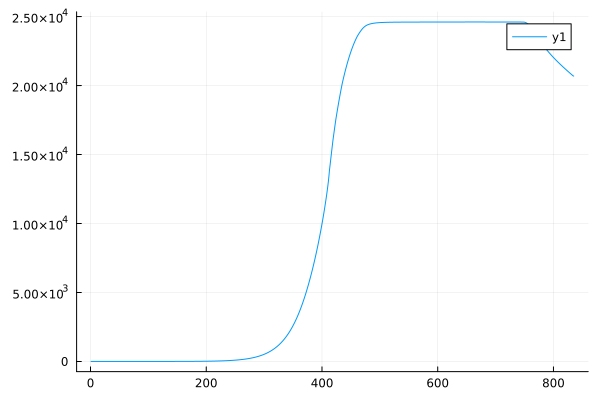

In [60]:
xs = aggregate_values(unimolecular, unimol_sol; prefix='x')
plot(xs)

In [79]:
infConc = 1e4
infRate = 1e2
N = 3
bimol_u0 = [
1.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, infConc, 1.0, 1.0, 
infConc, 0.0, 0.0, 1.0, 0.0, 
0.0, 0.0, 0.0, 0.0, infConc, 
1.0, infConc, 0.0, 1.0, 0.0, 
0.0, 0.0, 0.0, 0.0, infConc, 
infConc, 
]
bimol_sol = simulate(bimolecular, bimol_u0, rate=2/60.0, leak=1, shadow=1)
z=2

1


2

Term{Real, Base.ImmutableDict{DataType, Any}}[x0(t), Ly0(t), Iy0(t), sx0(t), sLy0(t), sIy0(t), waste(t), Gy0(t), y0(t), y1(t), sGy0(t), sy0(t), sy1(t), x1(t), Ly1(t), Iy1(t), sx1(t), sLy1(t), sIy1(t), Gy1(t), y2(t), sGy1(t), sy2(t), x2(t), Ly2(t), Iy2(t), sx2(t), sLy2(t), sIy2(t), Gy2(t), sGy2(t)]Term{Real, Base.ImmutableDict{DataType, Any}}[x0(t), Ly0(t), Iy0(t), sx0(t), sLy0(t), sIy0(t), waste(t), Gy0(t), y0(t), y1(t), sGy0(t), sy0(t), sy1(t), x1(t), Ly1(t), Iy1(t), sx1(t), sLy1(t), sIy1(t), Gy1(t), y2(t), sGy1(t), sy2(t), x2(t), Ly2(t), Iy2(t), sx2(t), sLy2(t), sIy2(t), Gy2(t), sGy2(t)]

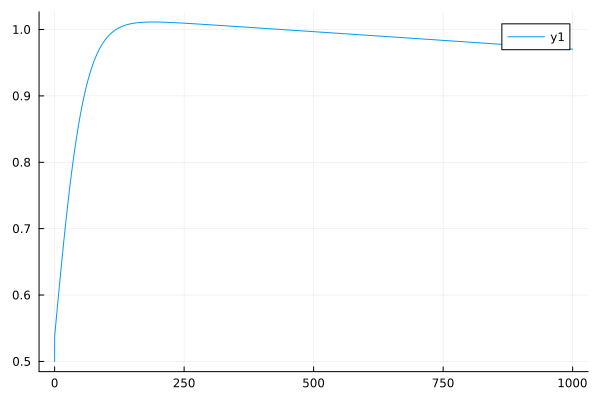

In [81]:
ys = aggregate_values(bimolecular, bimol_sol, prefix="y")
Lys = aggregate_values(bimolecular, bimol_sol, prefix="Ly")

y = (ys + Lys)/(2*N)
plot(bimol_sol.t, y)